## 1. Tworzenie macierzy spokrewnień

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

data=pd.read_csv('pedigree10.txt', sep='\t') #wczytanie danych pedigree
dane=data.as_matrix()

data.head()

,animal,sire,dam
0,216,14,70
1,217,12,17
2,218,6,106
3,219,15,42
4,220,1,91


In [59]:
def RelMatrixA(s,d):
    n = len(s)
    N = n + 1
    A = np.zeros((N,N))
    s = ( s == 0 ) * N + s
    d = ( d == 0 ) * N + d
    for i in range(n):
        A[i,i] = 1 + A[s[i]-1, d[i]-1] * 0.5
        for j in range(i+1,n):
            if j > n:
                break
            A[i,j] = (A[i,s[j]-1] + A[i,d[j]-1]) * 0.5
            A[j,i] = A[i,j]
    return A

In [60]:
n = len(dane[:,0])
wynik = RelMatrixA(dane[:,1],dane[:,2])[0:n,0:n]
print(wynik)

[[ 1.         0.         0.        ...,  0.25       0.         0.03125  ]
 [ 0.         1.         0.        ...,  0.         0.         0.       ]
 [ 0.         0.         1.        ...,  0.25       0.75       0.25     ]
 ..., 
 [ 0.25       0.         0.25      ...,  1.         0.1875     0.2578125]
 [ 0.         0.         0.75      ...,  0.1875     1.25       0.1875   ]
 [ 0.03125    0.         0.25      ...,  0.2578125  0.1875     1.       ]]


## 2. Predykcja dla zbioru testowego

In [61]:
dane_hod=pd.read_csv('dane10.txt', sep='\t') #wczytanie danych 
maska = np.random.rand(len(dane_hod)) < 0.8
testowy = dane_hod[maska]
walidacyjny = dane_hod[~maska]
dane_hodowlane=testowy.as_matrix()

{0: 2.0, 1: 3.0, 2: 1.0}


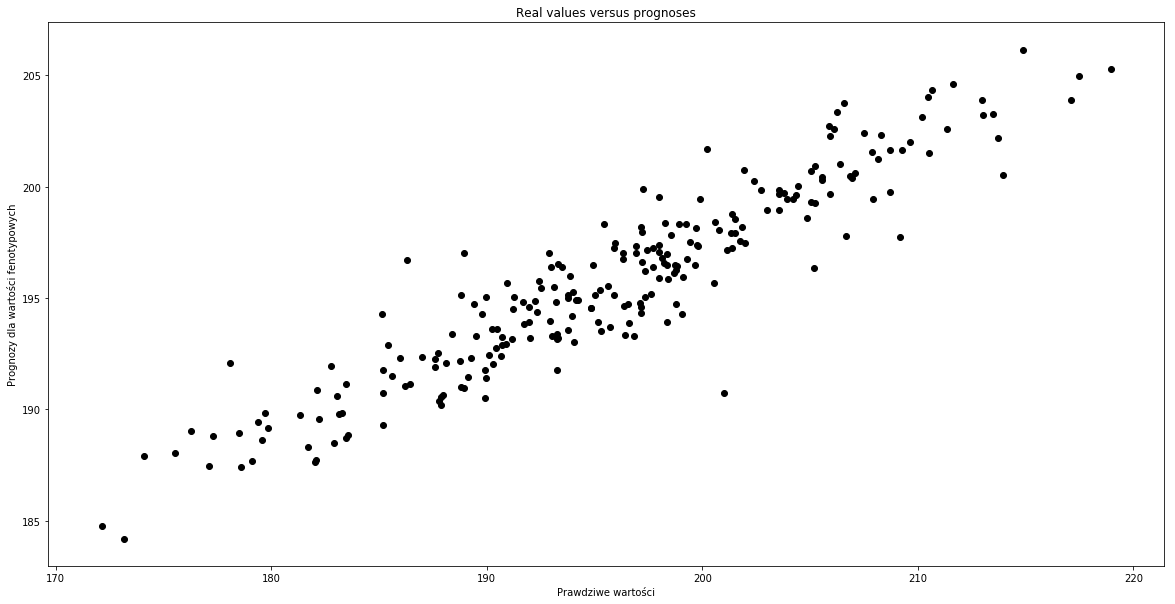

In [62]:
dane_hodowlane=testowy.as_matrix()
y = dane_hodowlane[:,1]
h2 = 0.48


List = []
for k in dane_hodowlane[:,2]:
    if k not in List:
        List.append(k)

herd = {}
for j in range(len(List)):
    herd[j] = List[j]
print(herd)
for i in range(len(herd)):
    if 'Trzecia' == herd[i]:
        print(herd[i])
x = np.zeros((len(dane_hodowlane), len(herd) + 1))
for i in range(len(x)):
    for j in range(len(herd)):
        if herd[j] == dane_hodowlane[:,2][i]:
            x[i][0], x[i][j+1] = 1, 1

z = np.zeros((len(y),len(y)+len(walidacyjny)))
np.fill_diagonal(z,1)
np.savetxt('macierz_stalych_testowy.txt',x)
np.savetxt('macierz_losowych_testowy.txt',z)
A = wynik
odwrA=np.linalg.inv(A)
x_t = x.transpose()
z_t = z.transpose()
L11=x_t.dot(x)
L21=z_t.dot(x)
L12=x_t.dot(z)
L22=z_t.dot(z)+odwrA*(1-h2)/h2
L1 =np.column_stack((L11, L12))
L2 =np.column_stack((L21, L22))
L = np.concatenate([L1, L2])
odwrL = np.linalg.pinv(L)
P1 = x_t.dot(y)
P2 = z_t.dot(y)
P = np.concatenate([P1, P2])
result=odwrL.dot(P)
b = result[0:len(herd)+1]
a = result[len(herd)+1:]
predy = x.dot(b) + z.dot(a)
e = predy - y

plt.figure(figsize=(20,10))
for i in range(len(predy)):
    plt.scatter(y[i], predy[i], color = 'black')
plt.title('Real values versus prognoses')
plt.xlabel('Prawdziwe wartości')
plt.ylabel('Prognozy dla wartości fenotypowych')
plt.show()

In [63]:
predylist = []
for i in range(len(predy)):
    predylist.append(predy[i])
corr = stats.pearsonr(predylist, y)
print('Korelacja Pearsona: %15s' % corr[0])
print('Wartość p: %27s' % corr[1])
print(len(dane_hodowlane[:,1]))

Korelacja Pearsona:  0.932997548129
Wartość p:          3.58190578753e-107
239


# 3. Predykcja dla zbioru walidacyjnego

In [49]:
dane=walidacyjny.as_matrix()
y = dane[:,1]


x = np.full((len(y),1), 1)
np.savetxt('macierz_stalych_walidacyjny.txt',x)
z = np.zeros((len(y),len(y)+len(dane_hodowlane[:,1])))
np.fill_diagonal(z,1)
np.savetxt('macierz_losowych_walidacyjny.txt',z)
predy = x.dot(b) + z.dot(a)
e = predy - y
plt.figure(figsize=(20,10))
for i in range(len(predy)):
    plt.scatter(y[i], predy[i][i], color = 'black')
plt.title('Real values versus prognoses')
plt.xlabel('Prawdziwe wartości')
plt.ylabel('Prognozy dla wartości fenotypowych')
plt.show()

[ 205.18  194.82  205.23  205.25  200.2   201.14  213.01  203.38  190.56
  200.58  197.98  217.5   197.24  185.99  183.07  178.51  197.17  182.2
  179.12  195.32  191.99  193.79  198.34  199.25  196.32  191.98  210.54
  187.97  188.37  191.94  208.39  207.93  205.54  207.51  215.49  196.32
  193.47  198.94  198.07  192.65  180.42  198.54  204.33  189.79  198.79
  193.75  203.81  174.3   185.62  197.17  188.99  184.93  186.99]


ValueError: shapes (53,1) and (4,) not aligned: 1 (dim 1) != 4 (dim 0)

In [45]:
predylist = []
for i in range(len(predy)):
    predylist.append(predy[i][i])
corr = stats.pearsonr(predylist, y)
print('Korelacja Pearsona: %15s' % corr[0])
print('Wartość p: %24s' % corr[1])

IndexError: invalid index to scalar variable.